In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
import logging
import math
import os
import random
import sys
import time
import pickle
import copy

import numpy as np
import torch

from fairseq import (
    checkpoint_utils,
    distributed_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from fairseq.data import iterators
from fairseq.logging import meters, metrics, progress_bar
from fairseq.trainer import Trainer
from fairseq.model_parallel.megatron_trainer import MegatronTrainer
from fairseq.models.pruned_transformer import PrunedTransformerModel

In [4]:
args = pickle.load(open("argsfile.p", "rb"))

In [5]:
print(args)

Namespace(activation_dropout=0.0, activation_fn='relu', adam_betas='(0.9, 0.98)', adam_eps=1e-08, adaptive_input=False, adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0, all_gather_list_size=16384, arch='pruned_transformer_vaswani_wmt_en_de_big', attention_dropout=0.0, best_checkpoint_metric='loss', bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_suffix='', clip_norm=0.0, cpu=False, criterion='label_smoothed_cross_entropy', cross_self_attention=False, curriculum=0, data='data-bin/wmt16_en_de_bpe32k', data_buffer_size=2, dataset_impl=None, ddp_backend='c10d', decoder_attention_heads=16, decoder_embed_dim=1024, decoder_embed_path=None, decoder_ffn_embed_dim=4096, decoder_input_dim=1024, decoder_layerdrop=0, decoder_layers=6, decoder_layers_to_keep=None, decoder_learned_pos=False, decoder_normalize_before=False, decoder_output_dim=1024, device_id=0, disable_validation=False, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=

In [9]:
task = tasks.setup_task(args)
model = task.build_model(args)
criterion = task.build_criterion(args)
if args.model_parallel_size == 1:
    trainer = Trainer(args, task, model, criterion, quantizer=None)
else:
    trainer = MegatronTrainer(args, task, model, criterion)



In [6]:
checkpoint_dir = "/home/raj/data/raj-learn/checkpoints/lr-rewind_0.75sparsity_0.2frac_30epochs/"
model_paths = ["checkpoint_LTH0_epoch60.pt",
              "checkpoint_LTH1_epoch60_sparsity0.168.pt",
              "checkpoint_LTH2_epoch60_sparsity0.302.pt",
              "checkpoint_LTH3_epoch60_sparsity0.410.pt", 
              "checkpoint_LTH4_epoch60_sparsity0.496.pt", 
              "checkpoint_LTH5_epoch60_sparsity0.565.pt",
              "checkpoint_LTH6_epoch60_sparsity0.620.pt",
              "checkpoint_LTH7_epoch60_sparsity0.664.pt"]
n_models = 7

# args.restore_file=checkpoint_dir+model_paths[0]
# extra_state, epoch_itr = checkpoint_utils.load_checkpoint(args, trainer)


In [9]:
trainer.load_checkpoint(checkpoint_dir+model_paths[0])
print(trainer.get_model().get_sparsity())
model1 = copy.deepcopy(trainer.get_model())
trainer.load_checkpoint(checkpoint_dir+model_paths[-1])
model2 = copy.deepcopy(trainer.get_model())


[209911808, 0, 0.0]


In [10]:
print(model1.get_sparsity())

[209911808, 0, 0.0]


In [11]:
print(model2.get_sparsity())

[209911808, 139324010, 0.6637263894081116]


In [ ]:
for name, param in model.named_parameters():
    param_props = PrunedTransformerModel.get_param_props(name)
    print(param_props, param)

In [79]:
def get_attention_sparsities(model):
    sparsities = np.zeros((3, 6, 4, 2))
    for name, param in model.named_parameters():
        param_props = PrunedTransformerModel.get_param_props(name)
        if param_props['type'] == 'attention':
            if param_props['module'] == 'encoder': j = 0
            elif param_props['attention'] == 'enc_dec': j = 1
            else: j = 2
            total_masked = (model.masks[name] == 0).sum().item()
            total_weights = model.masks[name].numel()
            qkv_to_idx = {'query': 0, 'key': 1, 'value': 2, 'out_proj': 3}
            sparsities[j][param_props['layer']][qkv_to_idx[param_props['proj']]][0] += total_masked
            sparsities[j][param_props['layer']][qkv_to_idx[param_props['proj']]][1] += total_weights
    type_sparsities = np.sum(sparsities, axis=(1,2))
    type_sparsities = type_sparsities[:,0] / type_sparsities[:,1]
    qkv_sparsities = np.sum(sparsities, axis=(0,1))
    qkv_sparsities = qkv_sparsities[:,0] / qkv_sparsities[:,1]
    layer_sparsities = np.sum(sparsities, axis=(0,2))
    layer_sparsities = layer_sparsities[:,0] / layer_sparsities[:,1]
    return type_sparsities, qkv_sparsities, layer_sparsities

In [83]:
all_type_sparsities, all_qkv_sparsities, all_layer_sparsities = [], [], []
for model_path in model_paths:
    trainer.load_checkpoint(checkpoint_dir+model_path)
    model = copy.deepcopy(trainer.get_model())
    type_sparsities, qkv_sparsities, layer_sparsities = get_attention_sparsities(model)
    all_type_sparsities.append(type_sparsities)
    all_qkv_sparsities.append(qkv_sparsities)
    all_layer_sparsities.append(layer_sparsities)
    del model

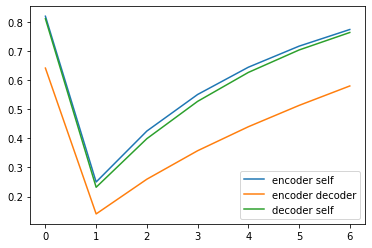

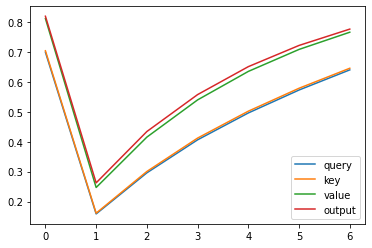

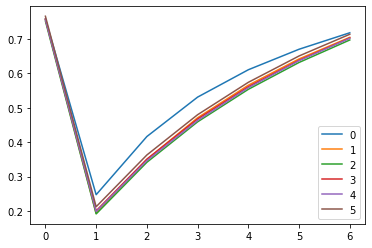

In [85]:
to_type = {0: 'encoder self', 1: 'encoder decoder', 2: 'decoder self'}
for i in range(3):
    plt.plot(np.arange(n_models), [all_type_sparsities[j][i] for j in range(n_models)])
plt.legend(to_type.values())
plt.show()

to_qkv = {0: 'query', 1: 'key', 2: 'value', 3: 'output'}
for i in range(4):
    plt.plot(np.arange(n_models), [all_qkv_sparsities[j][i] for j in range(n_models)])
plt.legend(to_qkv.values())
plt.show()

for i in range(6):
    plt.plot(np.arange(n_models), [all_layer_sparsities[j][i] for j in range(n_models)])
plt.legend(np.arange(6))
plt.show()

In [57]:
print(all_qkv_sparsities)

[array([0., 0., 0., 0.]), array([0.15899533, 0.16148692, 0.24712631, 0.2625939 ]), array([0.29605257, 0.300587  , 0.41519558, 0.43383744]), array([0.40613234, 0.41195418, 0.5393163 , 0.55700823]), array([0.49578707, 0.50167895, 0.63434419, 0.65023649]), array([0.57232094, 0.57815469, 0.70769875, 0.72100207]), array([0.63945709, 0.64488138, 0.76505637, 0.77544985]), array([0.69839616, 0.70325643, 0.81064787, 0.81835154])]


In [68]:
def get_l1_dists(original_model, model):
    dists = np.zeros((3, 6, 4, 2))
    original_params = list(original_model.parameters())
    for i, (name, param) in enumerate(model.named_parameters()):
        param_props = PrunedTransformerModel.get_param_props(name)
        if param_props['type'] == 'attention':
            if param_props['module'] == 'encoder': j = 0
            elif param_props['attention'] == 'enc_dec': j = 1
            else: j = 2
            total_dist = torch.abs(param - original_params[i]).sum()
            total_weights = param.numel()
            qkv_to_idx = {'query': 0, 'key': 1, 'value': 2, 'out_proj': 3}
            dists[j][param_props['layer']][qkv_to_idx[param_props['proj']]][0] += total_dist
            dists[j][param_props['layer']][qkv_to_idx[param_props['proj']]][1] += total_weights
    type_dists = np.sum(dists, axis=(1,2))
    type_dists = type_dists[:,0] / type_dists[:,1]
    qkv_dists = np.sum(dists, axis=(0,1))
    qkv_dists = qkv_dists[:,0] / qkv_dists[:,1]
    layer_dists = np.sum(dists, axis=(0,2))
    layer_dists = layer_dists[:,0] / layer_dists[:,1]
    return type_dists, qkv_dists, layer_dists

In [84]:
trainer.load_checkpoint(checkpoint_dir+model_paths[0])
original_model = copy.deepcopy(trainer.get_model())
all_type_dists, all_qkv_dists, all_layer_dists = [], [], []
for model_path in model_paths:
    trainer.load_checkpoint(checkpoint_dir+model_path)
    model_new = copy.deepcopy(trainer.get_model())
    type_dists, qkv_dists, layer_dists = get_l1_dists(original_model, model_new)
    all_type_dists.append(type_dists)
    all_qkv_dists.append(qkv_dists)
    all_layer_dists.append(layer_dists)
    del model_new
del original_model

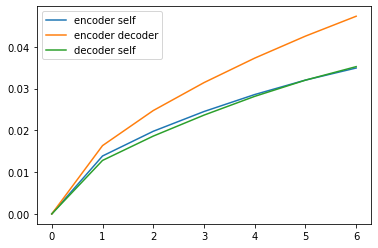

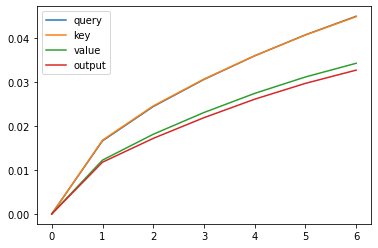

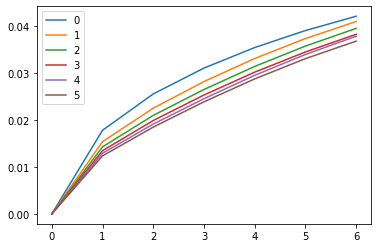

In [78]:
to_type = {0: 'encoder self', 1: 'encoder decoder', 2: 'decoder self'}
for i in range(3):
    plt.plot(np.arange(n_models), [all_type_dists[j][i] for j in range(n_models)])#, label=to_type[i])
plt.legend(to_type.values())
plt.show()

to_qkv = {0: 'query', 1: 'key', 2: 'value', 3: 'output'}
for i in range(4):
    plt.plot(np.arange(n_models), [all_qkv_dists[j][i] for j in range(n_models)])#, label=to_type[i])
plt.legend(to_qkv.values())
plt.show()

for i in range(6):
    plt.plot(np.arange(n_models), [all_layer_dists[j][i] for j in range(n_models)])#, label=to_type[i])
plt.legend(np.arange(6))
plt.show()


In [7]:
def get_svd(model, var_thresh=.99):
    pca = PCA()
    components = np.zeros((3, 6, 4))
    for i, (name, param) in enumerate(model.named_parameters()):
        param_props = PrunedTransformerModel.get_param_props(name)
        if param_props['type'] == 'attention' and param_props['weightorbias'] == 'weight':
            if param_props['module'] == 'encoder': j = 0
            elif param_props['attention'] == 'enc_dec': j = 1
            else: j = 2
            pca.fit(param.detach().cpu().numpy())
            explained_var = pca.explained_variance_ratio_
            total_var = 0
            for i in range(explained_var.shape[0]):
                total_var += explained_var[0]
                if total_var >= var_thresh: break
            i += 1
            total_dims = 1024
            
            qkv_to_idx = {'query': 0, 'key': 1, 'value': 2, 'out_proj': 3}
            components[j][param_props['layer']][qkv_to_idx[param_props['proj']]] = i / total_dims
                
    type_components = np.mean(components, axis=(1,2))
    type_components_std = np.std(components, axis=(1,2))
    qkv_components = np.mean(components, axis=(0,1))
    qkv_components_std = np.std(components, axis=(0,1))
    layer_components = np.mean(components, axis=(0,2))
    layer_components_std = np.std(components, axis=(0,2))

    return type_components, type_components_std, qkv_components, qkv_components_std, layer_components, layer_components_std

In [13]:
trainer.load_checkpoint(checkpoint_dir+model_paths[0])
all_type_components, all_qkv_components, all_layer_components = [], [], []
all_type_components, all_qkv_components, all_layer_components = [], [], []
for model_path in model_paths:
    trainer.load_checkpoint(checkpoint_dir+model_path)
    model = copy.deepcopy(trainer.get_model())
    type_components, _, qkv_components, _, layer_components, _ = get_svd(model)
    all_type_components.append(type_components)
    all_qkv_components.append(qkv_components)
    all_layer_components.append(layer_components)
    del model

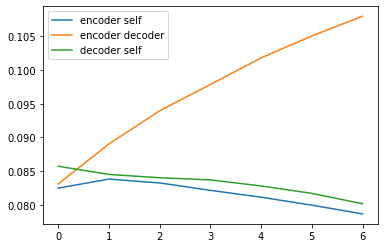

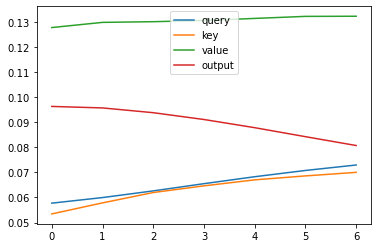

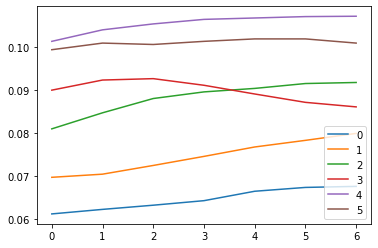

In [14]:
to_type = {0: 'encoder self', 1: 'encoder decoder', 2: 'decoder self'}
for i in range(3):
    plt.plot(np.arange(n_models), [all_type_components[j][i] for j in range(n_models)])
plt.legend(to_type.values())
plt.show()

to_qkv = {0: 'query', 1: 'key', 2: 'value', 3: 'output'}
for i in range(4):
    plt.plot(np.arange(n_models), [all_qkv_components[j][i] for j in range(n_models)])
plt.legend(to_qkv.values())
plt.show()

for i in range(6):
    plt.plot(np.arange(n_models), [all_layer_components[j][i] for j in range(n_models)])
plt.legend(np.arange(6))
plt.show()

In [43]:
def get_head_sparsities(model):
    sparsities = np.zeros((3, 6, 16, 2)) 
    for name, param in model.named_parameters():
        param_props = PrunedTransformerModel.get_param_props(name)
        if param_props['type'] == 'attention' and param_props['weightorbias'] == 'weight':
            if param_props['module'] == 'encoder': j = 0
            elif param_props['attention'] == 'enc_dec': j = 1
            else: j = 2
            for head in range(16):
                masks = model.masks[name][:, head*64:(head+1)*64].detach().cpu().numpy()
                total_masked = (masks == 0).sum().item()
                total_weights = model.masks[name][:, head*64:(head+1)*64].numel()
                sparsities[j][param_props['layer']][head][0] += total_masked
                sparsities[j][param_props['layer']][head][1] += total_weights
              
    sparsities = sparsities[:,:,:,0] / sparsities[:,:,:,1]
    return sparsities
#     type_sparsities = np.sum(sparsities, axis=(1,2))
#     type_sparsities = type_sparsities[:,0] / type_sparsities[:,1]
#     qkv_sparsities = np.sum(sparsities, axis=(0,1))
#     qkv_sparsities = qkv_sparsities[:,0] / qkv_sparsities[:,1]
#     layer_sparsities = np.sum(sparsities, axis=(0,2))
#     layer_sparsities = layer_sparsities[:,0] / layer_sparsities[:,1]
#     return type_sparsities, qkv_sparsities, layer_sparsities

In [44]:
trainer.load_checkpoint(checkpoint_dir+model_paths[-1])
model = copy.deepcopy(trainer.get_model())
head_sparsities = get_head_sparsities(model)
del model

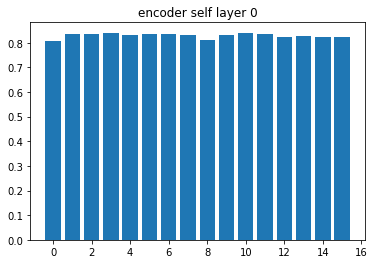

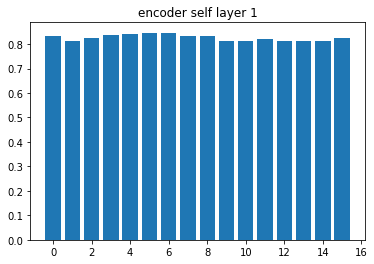

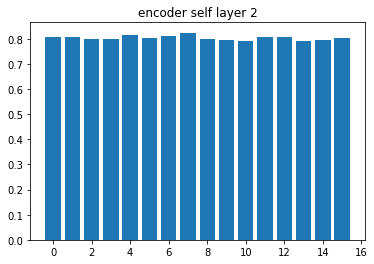

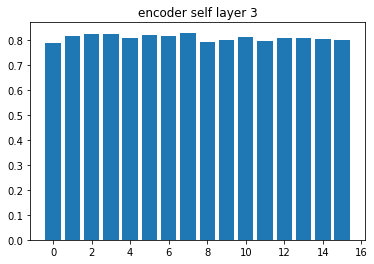

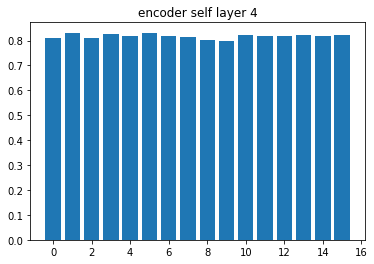

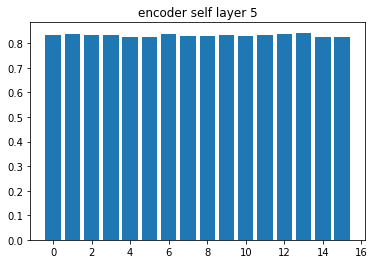

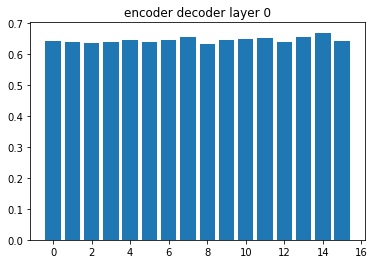

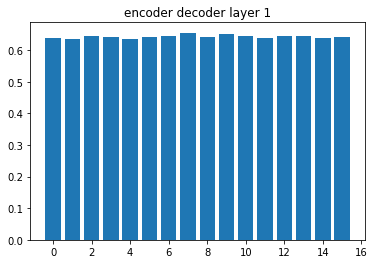

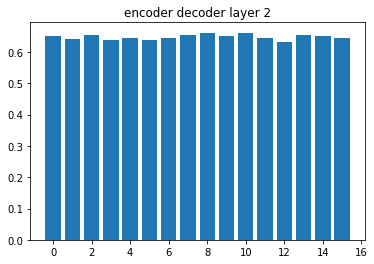

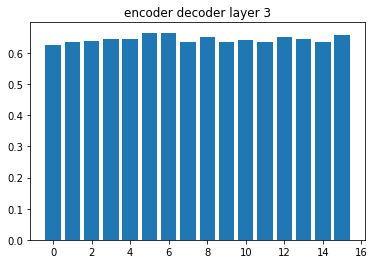

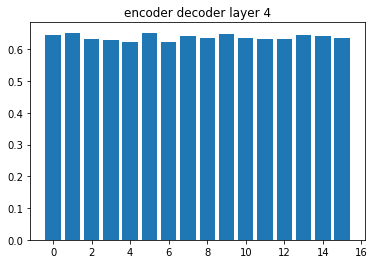

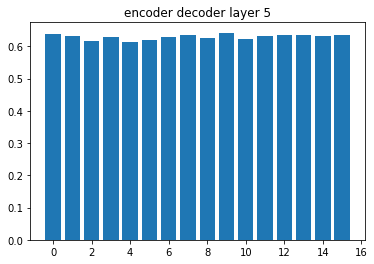

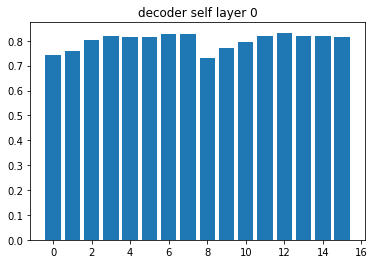

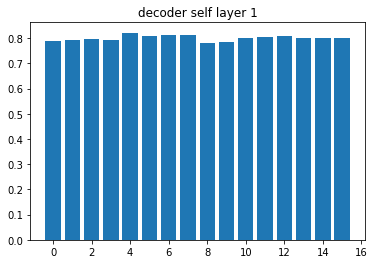

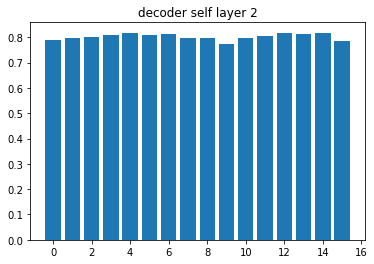

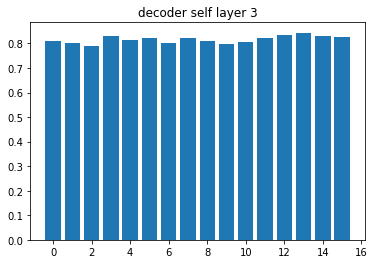

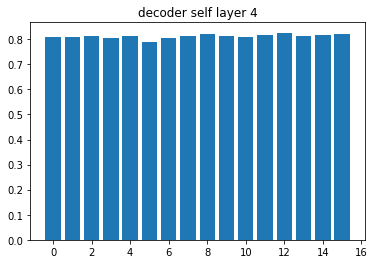

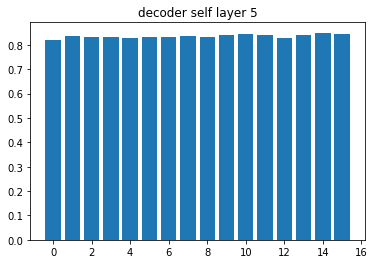

In [45]:
for i, module in enumerate(['encoder self', 'encoder decoder', 'decoder self']):
    for j in range(6):
        plt.bar(np.arange(16), head_sparsities[i,j,:])
        plt.title(module + " layer " + str(j))
        plt.show()

In [46]:
def get_fc_sparsities(model):
    sparsities = np.zeros((2, 6, 2))
    for name, param in model.named_parameters():
        param_props = PrunedTransformerModel.get_param_props(name)
        if param_props['type'] == 'fc':
            if param_props['module'] == 'encoder': j = 0
            else: j = 1
            total_masked = (model.masks[name] == 0).sum().item()
            total_weights = model.masks[name].numel()
            sparsities[j][param_props['layer']][0] += total_masked
            sparsities[j][param_props['layer']][1] += total_weights
    sparsities = sparsities[:,:,0] / sparsities[:,:,1]
    return sparsities

In [47]:
trainer.load_checkpoint(checkpoint_dir+model_paths[0])
all_fc_sparsities = []
for model_path in model_paths:
    trainer.load_checkpoint(checkpoint_dir+model_path)
    model = copy.deepcopy(trainer.get_model())
    sparsities = get_fc_sparsities(model)
    all_fc_sparsities.append(sparsities)
    del model

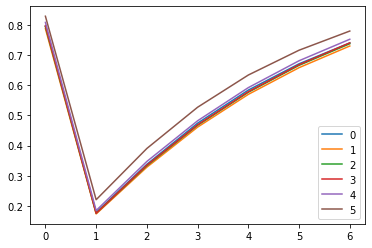

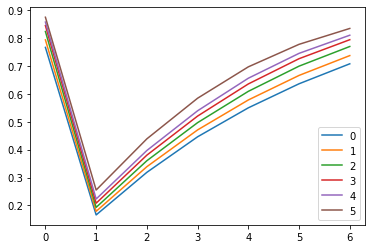

In [49]:
for i in range(6):
    plt.plot(np.arange(n_models), [all_fc_sparsities[j][0][i] for j in range(n_models)])
plt.legend(np.arange(6))
plt.show()

for i in range(6):
    plt.plot(np.arange(n_models), [all_fc_sparsities[j][1][i] for j in range(n_models)])
plt.legend(np.arange(6))
plt.show()